In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import Model 
from tensorflow.keras.layers import Input , GlobalAveragePooling2D , BatchNormalization , Dropout , Dense 
from tensorflow.keras.applications import EfficientNetB3 
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping 

In [2]:
!nvidia-smi

Wed Oct  5 07:41:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
dir = "../input/state-farm-distracted-driver-detection"
train_dir = os.path.join(dir , 'imgs/train/')
test_dir = os.path.join(dir , 'imgs/test/')
data = pd.read_csv(os.path.join(dir , 'driver_imgs_list.csv'))

In [4]:
data.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


<AxesSubplot:>

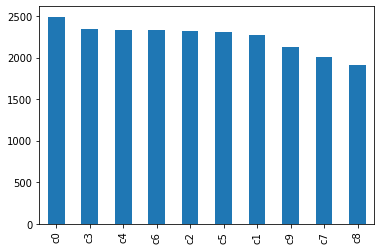

In [5]:
class_counts = data.classname.value_counts()

class_counts.plot(kind = 'bar')

In [6]:
IMG_SIZE = (224 ,224)
BATCH_SIZE = 64

In [7]:
train_gen = ImageDataGenerator(width_shift_range = 0.3,
                               height_shift_range = 0.3,
                               shear_range = 0.3,
                               zoom_range = 0.4,
                               validation_split = 0.2)

test_gen = ImageDataGenerator()

In [8]:
train_data = train_gen.flow_from_directory(train_dir,
                                         target_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         subset='training',
                                         seed = 42)

Found 17943 images belonging to 10 classes.


In [9]:
val_data = train_gen.flow_from_directory(train_dir,
                                         target_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         subset='validation',
                                         seed = 42)

Found 4481 images belonging to 10 classes.


In [10]:
def model(num_class):
    inputs = Input(shape=(224,224,3))
    base = EfficientNetB3(include_top = False,
                         weights='imagenet')(inputs)
    x = GlobalAveragePooling2D()(base)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_class , activation='softmax')(x)
    
    model = Model(inputs = inputs , outputs = outputs)
    model.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.optimizers.Adam(1e-4),
                 metrics = ['accuracy'])
    return model

In [11]:
num_class = len(class_counts )
num_class

10

In [12]:
model = model(num_class)
model.summary()

2022-10-05 07:41:10.850785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 07:41:10.860944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 07:41:10.861671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 07:41:10.862864: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, None, None, 1536)  10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                15370     
Total params: 10,805,049
Trainable params: 10,714,674
Non-trainable params: 90,375
____________________________________________

In [13]:
ck = ModelCheckpoint('best_model.hdf5' , save_best_only=True,monitor='val_loss',mode='min')
es = EarlyStopping(monitor = 'val_loss', patience = 5)


In [14]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5520145248462537631
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16149905408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16096961331619037842
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


2022-10-05 07:41:15.320008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 07:41:15.320586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 07:41:15.320944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 07:41:15.321299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 07:41:15.321662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [15]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
history = model.fit(train_data , 
                   epochs = 10 ,
                   validation_data = val_data ,
                   callbacks=[es,ck],
                   verbose = 1)

2022-10-05 07:41:16.351675: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-10-05 07:41:30.771599: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


281/281 [==============================] - 532s 2s/step - loss: 0.9545 - accuracy: 0.6950 - val_loss: 0.2324 - val_accuracy: 0.9268


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
281/281 [==============================] - 431s 2s/step - loss: 0.2112 - accuracy: 0.9350 - val_loss: 0.1079 - val_accuracy: 0.9670
Epoch 3/10
281/281 [==============================] - 431s 2s/step - loss: 0.1278 - accuracy: 0.9593 - val_loss: 0.0733 - val_accuracy: 0.9788
Epoch 4/10
281/281 [==============================] - 431s 2s/step - loss: 0.0876 - accuracy: 0.9724 - val_loss: 0.0591 - val_accuracy: 0.9817
Epoch 5/10
281/281 [==============================] - 433s 2s/step - loss: 0.0677 - accuracy: 0.9785 - val_loss: 0.0538 - val_accuracy: 0.9846
Epoch 6/10
281/281 [==============================] - 429s 2s/step - loss: 0.0570 - accuracy: 0.9816 - val_loss: 0.0337 - val_accuracy: 0.9911
Epoch 7/10
281/281 [==============================] - 432s 2s/step - loss: 0.0517 - accuracy: 0.9841 - val_loss: 0.0487 - val_accuracy: 0.9857
Epoch 8/10
281/281 [==============================] - 433s 2s/step - loss: 0.0422 - accuracy: 0.9865 - val_loss: 0.0330 - val_accuracy: 0.9900

In [22]:
test_dir = os.path.join(dir , 'imgs')
test_data = test_gen.flow_from_directory(test_dir ,
                                        target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE,
                                        classes = ['test'],
                                        shuffle = False)


Found 79726 images belonging to 1 classes.


In [24]:
from tensorflow.keras.models import load_model
model = load_model('./best_model.hdf5')

In [25]:
preds = model.predict(test_data)
preds

array([[4.8831641e-03, 1.6317997e-03, 5.0348201e-04, ..., 1.8780939e-03,
        6.5777493e-03, 9.2951357e-01],
       [2.1822155e-01, 6.5526292e-05, 1.1692665e-05, ..., 8.7242579e-04,
        1.3755855e-02, 8.7074563e-03],
       [6.2782913e-01, 1.1847745e-02, 1.2151502e-03, ..., 2.4923326e-02,
        3.1731078e-01, 1.3517874e-02],
       ...,
       [1.4628314e-02, 6.4014934e-04, 1.6073221e-03, ..., 1.3897051e-01,
        1.2899657e-01, 2.0249659e-02],
       [6.9536989e-05, 1.9210345e-06, 1.1906074e-04, ..., 4.2465981e-05,
        4.7203354e-03, 8.0740783e-06],
       [9.7370549e-04, 2.2127801e-04, 5.1116599e-06, ..., 2.5276193e-02,
        2.5801845e-03, 2.7535314e-04]], dtype=float32)

In [30]:
len(preds)

79726

In [31]:
test_imgs = os.path.join(dir , 'imgs/test')
test_ids = sorted(os.listdir(test_imgs))
pred_df = pd.DataFrame(columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
for i in range(len(preds)):
    pred_df.loc[i,'img'] = test_ids[i]
    pred_df.loc[i , 'c0':'c9'] = preds[i]
    

In [32]:
pred_df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.004883,0.001632,0.000503,0.001215,0.000511,0.053279,0.000008,0.001878,0.006578,0.929514
1,img_10.jpg,0.218222,0.000066,0.000012,0.000002,0.000074,0.758268,0.000022,0.000872,0.013756,0.008707
2,img_100.jpg,0.627829,0.011848,0.001215,0.000349,0.000353,0.000467,0.002187,0.024923,0.317311,0.013518
3,img_1000.jpg,0.00628,0.000575,0.010382,0.000022,0.009769,0.000039,0.004264,0.008675,0.958389,0.001606
4,img_100000.jpg,0.000737,0.000001,0.000001,0.992347,0.002079,0.000194,0.000032,0.00013,0.003393,0.001086
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.000004,0.998444,0.0,0.0,0.000001,0.000006,0.000001,0.000381,0.001151,0.000012
79722,img_99995.jpg,0.006206,0.000008,0.000012,0.795209,0.001396,0.001388,0.000227,0.008024,0.102979,0.08455
79723,img_99996.jpg,0.014628,0.00064,0.001607,0.010013,0.678681,0.002566,0.003647,0.138971,0.128997,0.02025
79724,img_99998.jpg,0.00007,0.000002,0.000119,0.000007,0.000003,0.000027,0.995001,0.000042,0.00472,0.000008


In [33]:
pred_df.to_csv('submission.csv',index = False)